In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import t

In [4]:
#calculate TSP
vol_D2O_TSP_uL = 5
total_vol_uL = 600
uL_to_L = 1e-6
D2O_density = 1.11 # 1 g/mL = 1 mg/uL
D2O_TSP_mg = vol_D2O_TSP_uL * D2O_density
TSP_wt_frac = 0.75/100
TSP_Mw = 172.27
TSP_mmol = TSP_wt_frac * D2O_TSP_mg / TSP_Mw
TSP_mM = TSP_mmol / (total_vol_uL * uL_to_L)
print('TSP:', '%.2f' % TSP_mM, 'mM')

TSP: 0.40 mM


In [6]:
files=['timeresolved_FsC', 'timeresolved_FsC_T45P_2', 'timeresolved_FsC_L182A_2', 'timeresolved_LCCICCG_2']
names=['FsC wt', 'FsC T45P', 'FsC L182A', 'LCC-ICCG']
time=np.arange(1,12+1,1)*5 
datalist=[]
for i in range(0,len(files)):
    data=np.loadtxt(files[i], delimiter=';', usecols=(1,2,3,4))
    assert len(data) == len(time)
    datalist.append(data)

In [7]:
def change_units(rate, uncertainty, MW):
    c_enzyme=1e-6
    V=600e-6
    n_enzyme=c_enzyme*V
    m_enzyme=MW*n_enzyme
    n_BHET=rate*V*1e-6
    err=uncertainty*V*1e-6
    rate_newunit=n_BHET*1e6/m_enzyme/60 #unit is umol/(g*s)
    uncertainty_newunit=err*1e6/m_enzyme/60 #unit is umol/(g*s)
    return rate_newunit, uncertainty_newunit

In [ ]:
MWs=[22258, 22258, 22258, 27774] #Molecular weights of the proteins

slope (95%) [uM/min]: -18.56 +/- 1.63
slope (95%) [umol/(g*s)]: -13.90 +/- 1.22
slope (95%) [uM/min]: -13.17 +/- 0.83
slope (95%) [umol/(g*s)]: -9.86 +/- 0.62
slope (95%) [uM/min]: -6.14 +/- 0.72
slope (95%) [umol/(g*s)]: -4.60 +/- 0.54
slope (95%) [uM/min]: -41.22 +/- 12.27
slope (95%) [umol/(g*s)]: -24.74 +/- 7.37


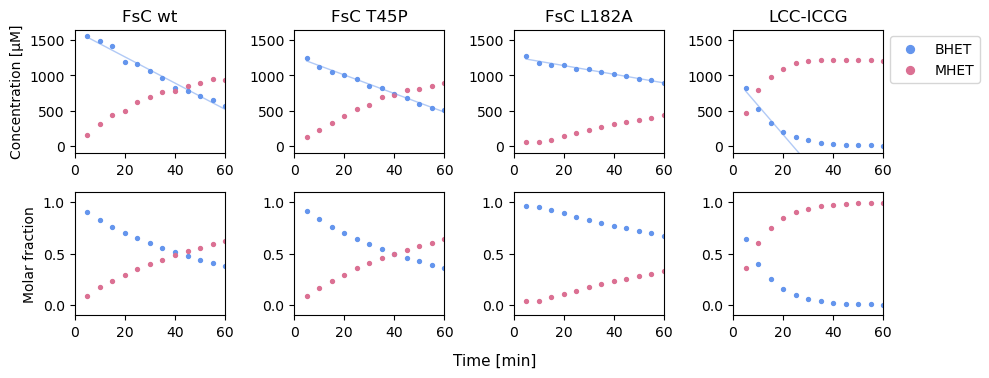

nan

In [9]:
#plots
fig, axs = plt.subplots(2,4, figsize=(10,3.6))
slope_concentration=[] #slopes measured in microM/minute
slope_fraction=[] #slopes measured in molar fraction/minute
error_slopes=[]
TSP_list=[]
for i in range(0,len(files)):
    data=datalist[i]
    TSP = (data[:,3]/9)
    BHET = 1e3 * TSP_mM * (data[:,0]/4)/TSP
    MHET = 1e3 * TSP_mM * ((data[:,1] + data[:,2])/4)/TSP
    #TPA = 1e3 * TSP_mM * (data[:,4]/4)/TSP
    SD = np.std(TSP*1e3)
    
    axs[0,i].scatter(time,BHET,s=8, color='cornflowerblue', label='BHET')
    axs[0,i].scatter(time,MHET, s=8, color='palevioletred', label='MHET')
    axs[0,i].set_ylim(-100,1650)

    #Find rates of BHET degradation
    if i==3: #linear region of LCC-ICCG
        linreg = stats.linregress(time[:4],BHET[:4])
    else: 
        linreg = stats.linregress(time,BHET)
    slope=linreg.slope
    intercept=linreg.intercept
    slope_concentration.append(slope)
    error_slopes.append(linreg.stderr)
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(time)-2)
    print(f"slope (95%) [uM/min]: {linreg.slope:.2f} +/- {ts*linreg.stderr:.2f}")
    rate_newunit, err_newunit=change_units(linreg.slope, linreg.stderr, MWs[i])
    print(f"slope (95%) [umol/(g*s)]: {rate_newunit:.2f} +/- {ts*err_newunit:.2f}") #unit is umol/(gram enzyme)

    axs[0,i].plot(time, slope*time+intercept, color='cornflowerblue', alpha=0.5, linewidth=1)


    #Plot fractions
    axs[1,i].scatter(time,BHET/(MHET+BHET), s=8, c='cornflowerblue', label = 'BHET')
    axs[1,i].scatter(time,MHET/(MHET+BHET), s=8, c='palevioletred', label = 'MHET')
    axs[0,i].set_title(names[i])
    axs[1,i].set_ylim(-0.1,1.1)
    axs[0,i].set_xlim(0,60)
    axs[1,i].set_xlim(0,60)
    slope, intercept, r_value, p_value, std_err = stats.linregress(time,BHET/(MHET+BHET))
    slope_fraction.append(slope)

axs[0,3].legend(loc='best', markerscale=2, bbox_to_anchor=(1, 1))
axs[1,0].set_ylabel('Molar fraction')
axs[0,0].set_ylabel('Concentration [µM]')
fig.text(0.5, -0.03, r'Time [min]',  fontsize='11',ha='center')
plt.tight_layout()
plt.savefig("Timeresolved_BHET.png", bbox_inches="tight",
            pad_inches=0.3, dpi=300)
plt.show()


TSP_list=np.array(TSP_list)
std_devs = np.std(TSP_list, axis=0)
std_devs

<BarContainer object of 4 artists>

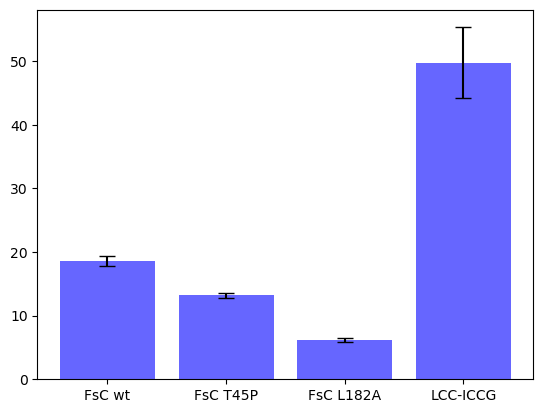

In [29]:
plt.bar(names, -1*np.array(slope_concentration), yerr=error_slopes, align='center', alpha=0.6, color='blue', ecolor='black', capsize=6)